# Spatial analysis of the Chicago transit system

This demonstration shows the power of the datashader library to make geospatial visualizations of public transport data in Chicago. The osmnx is used to compute the edge bearings of the Chicago GTFS data, the distribution of bearings properties of Chicago GTFS shows grid pattern in histgram distribution plotting and polar plotting.

The General Transit Feed Specification—or GTFS—is an open format for packaging scheduled service data. GTFS data is produced by hundreds of transit agencies around the world to deliver content for inclusion in maps and directions-giving services, including Google Maps.

## Set up the environment, loading library, download the GTFS data in Chicago, and load the GTFS data in Chicago

In [14]:

%matplotlib inline

import osmnx as ox, matplotlib.pyplot as plt
ox.config(log_console=True, use_cache=True)

import networkx as nx
import pandas as pd


import requests
import shutil
import os
import zipfile

req = requests.get('http://gtfs.s3.amazonaws.com/chicago-transit-authority_20160416_0123.zip', stream=True)
with open('chicago-transit-authority_20160416_0123.zip', 'wb') as file:
    shutil.copyfileobj(req.raw, file)
    
if not os.path.exists('./gtfsdata'):
    os.mkdir('./gtfsdata')
    
with zipfile.ZipFile('chicago-transit-authority_20160416_0123.zip', 'r') as file:
    file.extractall('./gtfsdata')

os.listdir('./gtfsdata')

['developers_license_agreement.htm',
 'transfers.txt',
 'agency.txt',
 'calendar_dates.txt',
 'stop_times.txt',
 'frequencies.txt',
 'shapes.txt',
 'trips.txt',
 'stops.txt',
 'calendar.txt',
 'routes.txt']

## Read the GTFS trips, shapes, stops data from the gftsdata directory

In [15]:
trips  = pd.read_csv('gtfsdata/trips.txt', low_memory=False)
shapes = pd.read_csv('gtfsdata/shapes.txt', low_memory=False)
stops  = pd.read_csv('gtfsdata/stops.txt', low_memory=False)


### Show the first 5 trips

In [16]:
print ('The numer of trips is:{}'.format(len(trips)))
trips.head(5)

The numer of trips is:90199


,route_id,service_id,trip_id,direction_id,block_id,shape_id,direction,wheelchair_accessible,schd_trip_id
0,1,46301,463099545089,0,463000002420,4636351,South,1,99545089
1,1,46301,463099545091,1,463000002422,4636353,North,1,99545091
2,1,46301,463099545103,1,463000002420,4636353,North,1,99545103
3,1,46301,463099545105,0,463000002434,4636351,South,1,99545105
4,1,46301,463099545106,0,463000002422,4636351,South,1,99545106


### Show the first 5 shapes

In [17]:
print ('The numer of shapes is:{}'.format(len(shapes)))
shapes.head(5)

The numer of shapes is:821679


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,19,41.886827,-87.626902,1,0
1,19,41.886827,-87.626902,2,66
2,19,41.886793,-87.624648,3,504
3,19,41.885150,-87.624552,4,1110
4,19,41.885048,-87.624544,5,1167


### Show the first 5 stops

In [18]:
print ('The numer of stops is:{}'.format(len(stops)))
stops.head(5)

The numer of stops is:11429


,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding
0,1,1.0,Jackson & Austin Terminal,"Jackson & Austin Terminal, Northeastbound, Bus...",41.876322,-87.774105,0,NaN,1
1,2,2.0,5900 W Jackson,"5900 W Jackson, Eastbound, Southside of the St...",41.877067,-87.771318,0,NaN,1
2,3,3.0,Jackson & Menard,"Jackson & Menard, Eastbound, Southside of the ...",41.876957,-87.769750,0,NaN,1
3,4,4.0,5700 W Jackson,"5700 W Jackson, Eastbound, Southside of the St...",41.877024,-87.767451,0,NaN,1
4,6,6.0,Jackson & Lotus,"Jackson & Lotus, Eastbound, Southeast Corner",41.876513,-87.761446,0,NaN,1


## Distributions of latitude and longitude for Chicago GTFS dataset

Text(0, 0.5, 'Frequency')

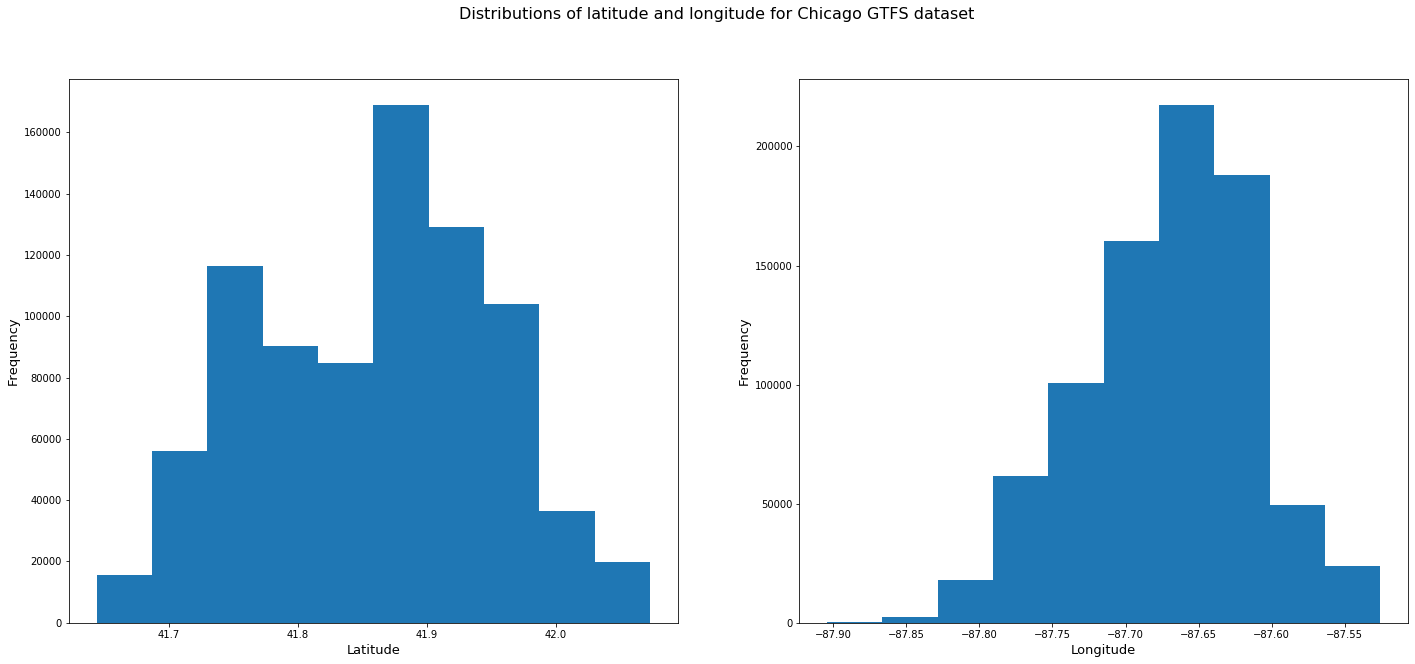

In [19]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Distributions of latitude and longitude for Chicago GTFS dataset', fontsize=16)
ax1.hist(shapes.shape_pt_lat)
ax1.set_xlabel('Latitude', fontsize=13)
ax1.set_ylabel('Frequency', fontsize=13)
ax2.hist(shapes.shape_pt_lon)
ax2.set_xlabel('Longitude', fontsize=13)
ax2.set_ylabel('Frequency', fontsize=13)

## Heatmap for GTFS data in Chicago area

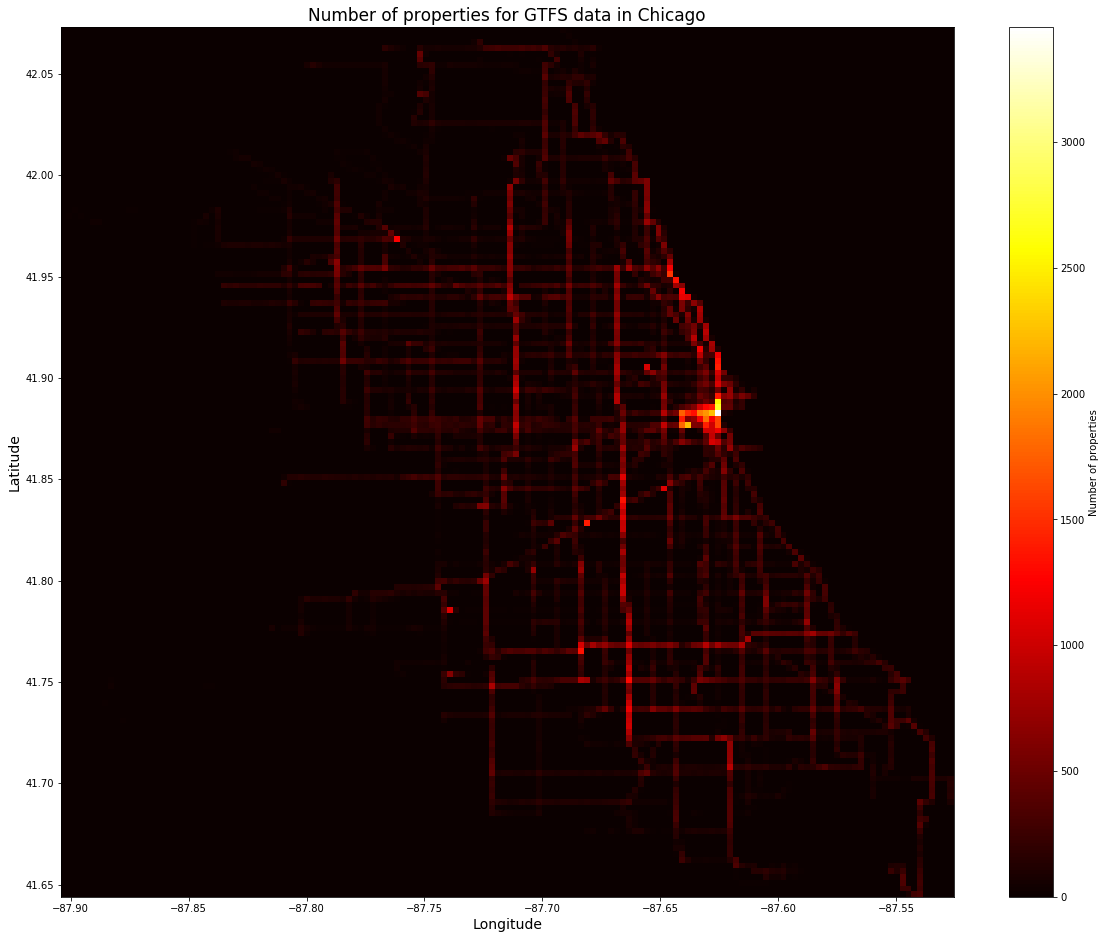

In [20]:
#Heatmap for the GTFS data in Chicago
import matplotlib.pyplot as plt

plt.figure(figsize = (20,16))
plt.hist2d(shapes.shape_pt_lon, shapes.shape_pt_lat, bins=150, cmap='hot')
plt.colorbar().set_label('Number of properties')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('Number of properties for GTFS data in Chicago', fontsize=17)

plt.show()

## Visualization for the GTFS data in Chicago

Datashader is a graphics pipeline system for creating meaningful representations of large datasets quickly and flexibly. Datashader breaks the creation of images into a series of explicit steps that allow computations to be done on intermediate representations (https://datashader.org/). 


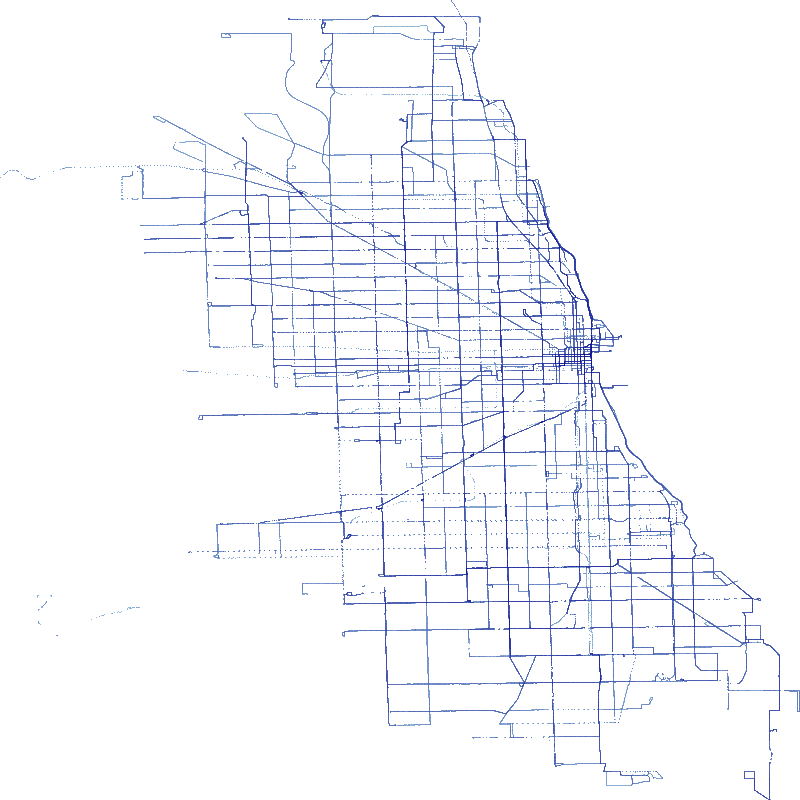

In [21]:
from __future__ import division 
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import os
import glob
import datashader as ds
import datashader.transfer_functions as tf

import folium

# Show GTFS data in Chicago

#maindt = shapes[abs(shapes.shape_pt_lon +87.6298) <= 0.95]
#maindt = maindt[abs(maindt.shape_pt_lat -41.8781 ) <= 0.95]
cvs = ds.Canvas(plot_width=800, plot_height=800)
agg = cvs.points(shapes,'shape_pt_lon','shape_pt_lat')
img = tf.shade(agg, cmap=['lightblue','darkblue'],how='log')
img

### generate a sorted list of unique route ids

In [22]:
def filter_by_int(seq):
    for el in seq:
        res = None
        try:
            res = int(el)
        except ValueError:
            pass
        if res: yield res

rts = pd.read_csv('gtfsdata/routes.txt', low_memory=False)
unique_routes = set(rts[~rts['route_short_name'].isnull()]['route_short_name'].values)
sorted_unique = sorted(filter_by_int(unique_routes))

print('The number of Routes in feed is : {}'.format(len(sorted_unique)))
print('Routes in feed: {}'.format(sorted_unique))

The number of Routes in feed is : 109
Routes in feed: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 19, 20, 21, 22, 24, 26, 28, 29, 30, 34, 35, 36, 37, 39, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 62, 63, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 96, 97, 100, 103, 106, 108, 111, 112, 115, 119, 120, 121, 124, 125, 126, 132, 134, 135, 136, 143, 146, 147, 148, 151, 152, 155, 156, 157, 165, 169, 170, 171, 172, 192, 201, 205, 206]


### Create the Network Graph using osmnx formart

Extract each shape related to that route separately. Because routes in GTFS can have multiple shapes.

In [23]:
#trips = gtfs_dfs['trips']

routes = rts
all_rts_shapes = {}
for rte_id in set(routes['route_id'].values):
    rte_trips = trips[trips['route_id'] == rte_id]
    rte_shapes = set(rte_trips['shape_id'].values)

    #shapes = gtfs_dfs['shapes']
    rte_sh_table = shapes[shapes['shape_id'].isin(rte_shapes)]

    sh_dict = {}
    for shid in rte_shapes:
        one_shid = rte_sh_table[rte_sh_table['shape_id'] == shid]
        sorted_shid_table = one_shid.sort_values(by='shape_pt_sequence', ascending=True)
        shid_list = []
        for id, row in sorted_shid_table.iterrows():
            shid_list.append({
                'id': id,
                'lon': row.shape_pt_lon,
                'lat': row.shape_pt_lat,
                'seq': row.shape_pt_sequence,
                'dist': row.shape_dist_traveled
            })
        sh_dict[shid] = shid_list
    
    # now update the reference list
    all_rts_shapes[rte_id] = sh_dict

### create a directed graph representing the transit network using osmnx

This stepd will need much time to process the Chicago network data

In [24]:
import hashlib
def _make_id(shape_id, item):
    
    s = ''.join([shape_id, str(item['seq'])]).replace('_', '')
    s = s.encode('utf-8')
    s_int = abs(int(hashlib.sha1(s).hexdigest(), 16) % (10 ** 12))
    return str(s_int)


def add_new_route_shape(route, shape_id, pot_nodes, G):
    # first add nodes to network
    kept_nodes = []
    for item in pot_nodes:
        #print (shape_id,item['id'])
        node_id = item['id'] #_make_id(shape_id, item)
       
        # if we can, check last node appended
        if len(kept_nodes):
            last_node = kept_nodes[-1]
            # make sure it isn't at same distance along
            # the route
            if last_node['dist'] == item['dist']:
                continue

        # add to the graph
        G.add_node(node_id, route=route,
                            shape_id=shape_id,
                            osmid=node_id,
                            x=item['lon'],
                            y=item['lat'])

        # and update list for tracking
        kept_nodes.append(item)

    # now add edges
    for a, b in zip(kept_nodes[:-1], kept_nodes[1:]):
        a_id = a['id']#_make_id(shape_id, a)
        b_id = b['id']#_make_id(shape_id, b)
        length = ox.utils.great_circle_vec(a['lat'],
                                           a['lon'],
                                           b['lat'],
                                           b['lon'])
        G.add_edge(a_id, b_id, attr_dict={'length': length,
                                          'route': route,
                                          'shape_id': shape_id})


G_rts = nx.MultiDiGraph(name='all_rts', crs={'init':'epsg:4326'})

all_rts_shapes_keys = list(all_rts_shapes.keys())
for rte_key in all_rts_shapes_keys:
    rte_shapes_dict = all_rts_shapes[rte_key]
    for rte_shape_id in rte_shapes_dict.keys():
        add_new_route_shape(rte_key, rte_shape_id, rte_shapes_dict[rte_shape_id], G_rts)

###  Show the transit network  in Chicago

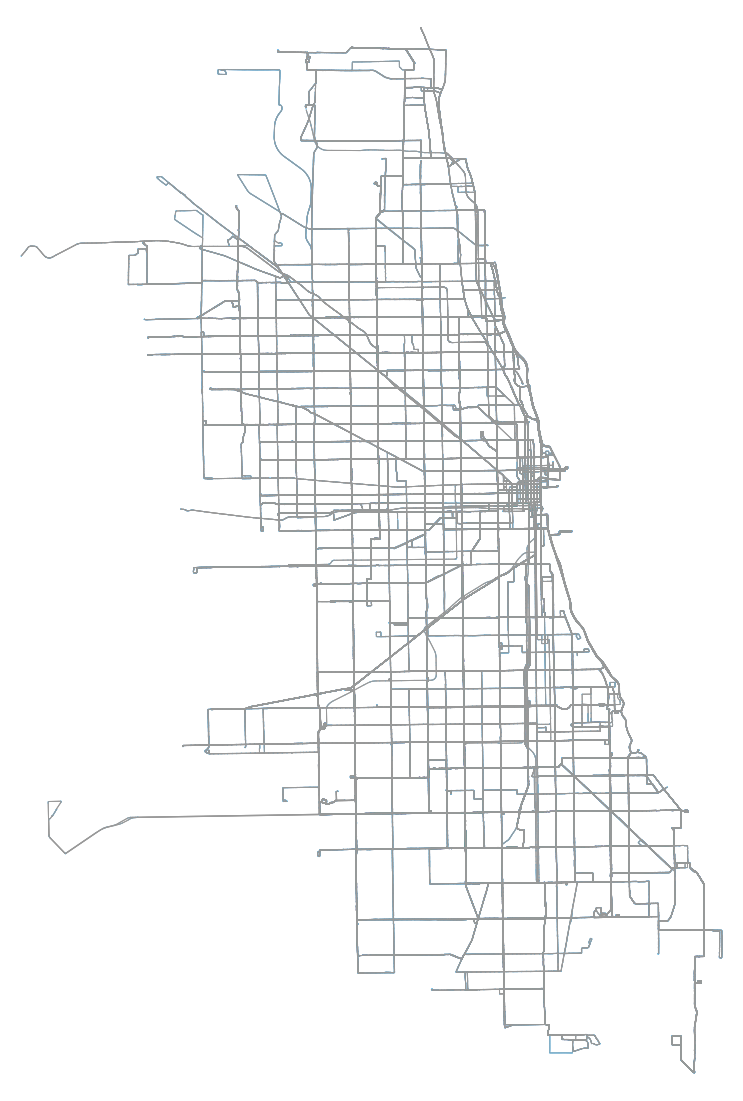

CPU times: user 11min 44s, sys: 12.5 s, total: 11min 57s
Wall time: 12min 9s


In [25]:
%time fig, ax = ox.plot_graph(ox.project_graph(G_rts), fig_height=20, node_size=1, dpi=600)

## Bearings Analysis in Chicago GTFS

###  calculate edge bearings 

In [26]:
import matplotlib.pyplot as plt

%time G_rts = ox.add_edge_bearings(G_rts)


### visualize the frequency of the GTFS edge bearings

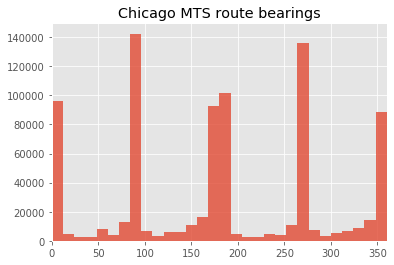

In [27]:
bearings = pd.Series([data['bearing'] for u, v, k, data in G_rts.edges(keys=True, data=True)])
ax = bearings.hist(bins=30, zorder=2, alpha=0.8)
xlim = ax.set_xlim(0, 360)
ax.set_title('Chicago MTS route bearings')
plt.show()

### polar plot for the frequency of the GTFS edge bearings

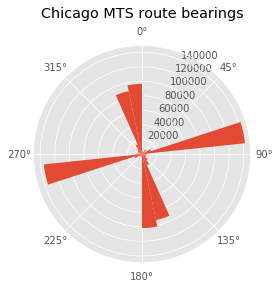

In [28]:

n = 30
count, division = np.histogram(bearings, bins=[ang*360/n for ang in range(0,n+1)])
division = division[0:-1]
width =  2 * np.pi/n
ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction('clockwise')
bars = ax.bar(division * np.pi/180 - width * 0.5 , count, width=width, bottom=20.0)
ax.set_title('Chicago MTS route bearings', y=1.1)
plt.show()

### playing with plotting the bearing of each segment of each route

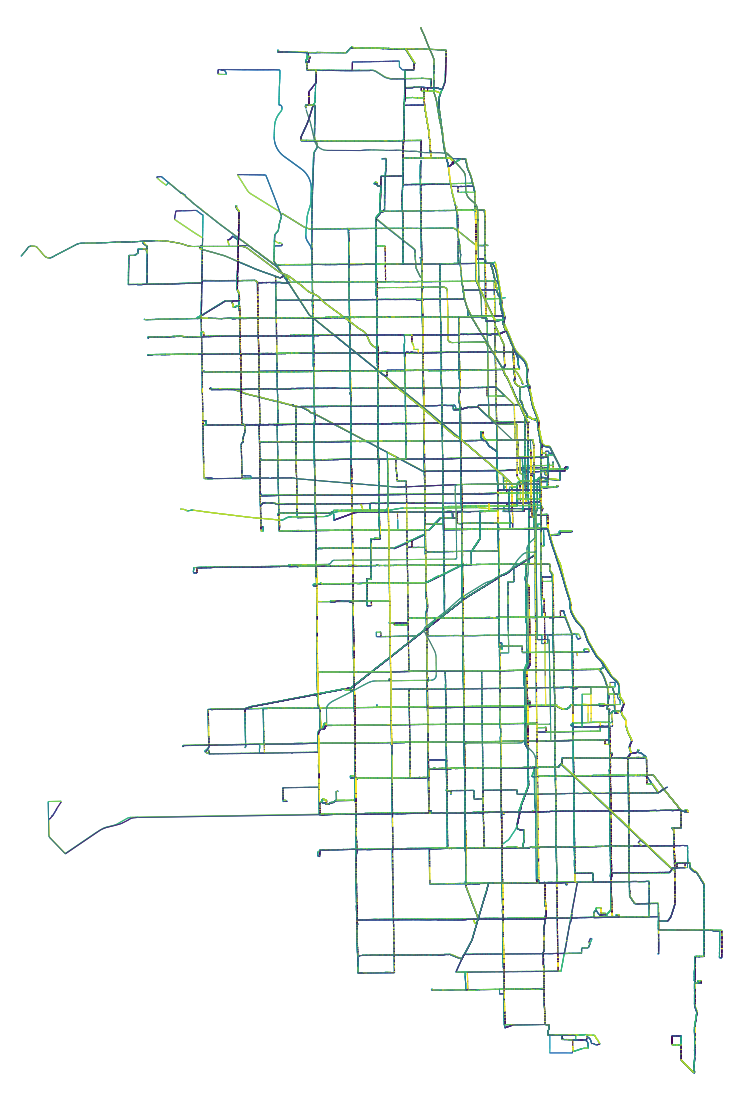

In [29]:
edge_colors = ox.get_edge_colors_by_attr(G_rts, 'bearing', num_bins=10, cmap='viridis', start=0, stop=1)
fig, ax = ox.plot_graph(ox.project_graph(G_rts), fig_height=20, node_size=1, edge_color=edge_colors, dpi=600)